In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# STEP 2: LOAD + CLEAN DATA
df = pd.read_csv("attendance_dataset_augmented.csv", nrows=50000)
df.dropna(subset=['Status', 'Lecture Duration', 'Day', 'CourseCode', 'Time Lecture Started'], inplace=True)
df.drop_duplicates(inplace=True)
df['Lecture Duration'] = pd.to_numeric(df['Lecture Duration'], errors='coerce')
df = df[(df['Lecture Duration'] > 0) & (df['Lecture Duration'] <= 180)]
df['Lecture Start Hour'] = df['Time Lecture Started'].astype(str).apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)
df['Status'] = df['Status'].str.lower()
df['label'] = df['Status'].apply(lambda x: 1 if x == 'present' else 0)

In [ ]:
# STEP 3: ENCODING
le_day = LabelEncoder()
le_course = LabelEncoder()
df['Day_enc'] = le_day.fit_transform(df['Day'].astype(str))
df['Course_enc'] = le_course.fit_transform(df['CourseCode'].astype(str))

In [ ]:
# STEP 4: FEATURE ENGINEERING
df.sort_values(by=["Student ID", "Date"], inplace=True)

# 1. Was present last time
df['was_present_last_time'] = df.groupby('Student ID')['label'].shift(1).fillna(0)

# 2. Rolling absences (last 7 lectures)
df['rolling_absences'] = (
    df.groupby('Student ID')['label']
    .transform(lambda x: x.rolling(7, min_periods=1).apply(lambda y: 7 - sum(y)))
    .fillna(0)
)

# 3. Time of day bucket
df['time_period'] = df['Lecture Start Hour'].apply(lambda h: 0 if h < 12 else (1 if h < 17 else 2))


In [ ]:
# STEP 5: DEFINE FEATURES
features = ['Day_enc', 'Course_enc', 'Lecture Duration', 'Lecture Start Hour',
            'was_present_last_time', 'rolling_absences', 'time_period']
X = df[features]
y = df['label']

In [ ]:
# STEP 6: SPLIT + BALANCE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# STEP 7: TUNE XGBOOST
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n🎯 Tuned XGBoost Results:")
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 8 candidates, totalling 24 fits

🎯 Tuned XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      5120
           1       0.64      1.00      0.78      2546

    accuracy                           0.81      7666
   macro avg       0.82      0.86      0.81      7666
weighted avg       0.88      0.81      0.82      7666



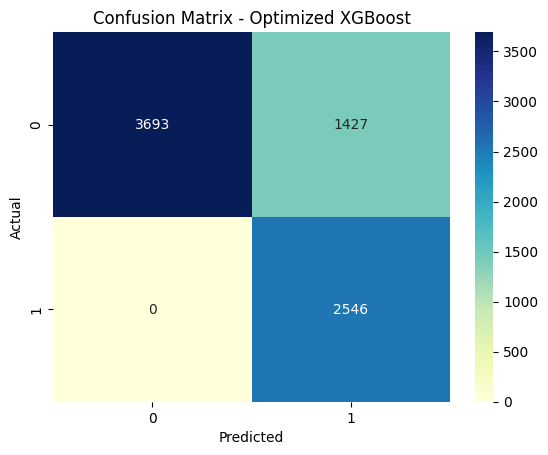

In [ ]:
# CONFUSION MATRIX
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Optimized XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# STEP 8: STACKING
ensemble = VotingClassifier(estimators=[
    ('xgb', best_model),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('logreg', LogisticRegression(max_iter=1000))
], voting='soft')

ensemble.fit(X_train_res, y_train_res)
y_pred_ensemble = ensemble.predict(X_test)
print("\n🤖 Stacked Ensemble Results:")
print(classification_report(y_test, y_pred_ensemble))



🤖 Stacked Ensemble Results:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      5120
           1       0.65      0.92      0.76      2546

    accuracy                           0.81      7666
   macro avg       0.80      0.84      0.80      7666
weighted avg       0.85      0.81      0.81      7666



In [ ]:
# STEP 9: MLP CLASSIFIER
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500)
mlp.fit(X_train_res, y_train_res)
y_pred_mlp = mlp.predict(X_test)

print("\n🧠 Neural Network (MLP) Results:")
print(classification_report(y_test, y_pred_mlp))


🧠 Neural Network (MLP) Results:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      5120
           1       0.64      1.00      0.78      2546

    accuracy                           0.81      7666
   macro avg       0.82      0.86      0.81      7666
weighted avg       0.88      0.81      0.82      7666



In [ ]:
# ✅ Additional features for stronger signals
df['is_weekend'] = df['Day'].isin(['Friday', 'Saturday']).astype(int)
df['is_first_period'] = df['Lecture Start Hour'].apply(lambda h: 1 if h <= 9 else 0)

# 🔁 Rolling average presence for last 3 lectures
df['last3_avg'] = (
    df.groupby('Student ID')['label']
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
    .fillna(0)
)


In [ ]:
features = ['Day_enc', 'Course_enc', 'Lecture Duration', 'Lecture Start Hour',
            'was_present_last_time', 'rolling_absences', 'time_period',
            'is_weekend', 'is_first_period', 'last3_avg']



🔥 Meta-Stacked Model Results:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      5120
           1       0.65      0.89      0.75      2546

    accuracy                           0.80      7666
   macro avg       0.79      0.83      0.79      7666
weighted avg       0.84      0.80      0.81      7666



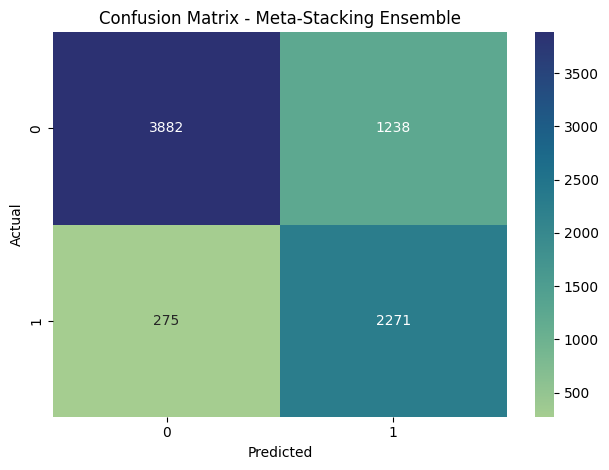

In [ ]:
from sklearn.ensemble import StackingClassifier

stack_model = StackingClassifier(
    estimators=[
        ('xgb', best_model),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('logreg', LogisticRegression(max_iter=1000))
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss')
)

stack_model.fit(X_train_res, y_train_res)
y_pred_stack = stack_model.predict(X_test)

print("\n🔥 Meta-Stacked Model Results:")
print(classification_report(y_test, y_pred_stack))

# Optional confusion matrix
conf_matrix_stack = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(conf_matrix_stack, annot=True, fmt='d', cmap='crest')
plt.title("Confusion Matrix - Meta-Stacking Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Train scaled MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500)
mlp.fit(X_train_res_scaled, y_train_res)
y_pred_mlp = mlp.predict(X_test_scaled)

print("\n🧠 MLP with Scaled Features:")
print(classification_report(y_test, y_pred_mlp))



🧠 MLP with Scaled Features:
              precision    recall  f1-score   support

           0       0.97      0.73      0.84      5120
           1       0.64      0.96      0.77      2546

    accuracy                           0.81      7666
   macro avg       0.81      0.85      0.80      7666
weighted avg       0.86      0.81      0.82      7666



In [ ]:
student_counts = df['Student ID'].value_counts()
valid_students = student_counts[student_counts >= 3].index
df = df[df['Student ID'].isin(valid_students)]


In [ ]:
!pip install lightgbm catboost

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# LightGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train_res, y_train_res)
print("\n🌿 LightGBM Results:")
print(classification_report(y_test, lgbm.predict(X_test)))

# CatBoost (can handle categories automatically!)
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train_res, y_train_res)
print("\n🐱 CatBoost Results:")
print(classification_report(y_test, cat.predict(X_test)))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20562, number of negative: 20562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 41124, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🌿 LightGBM Results:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      5120
           1       0.64      0.99      0.78      2546

    accuracy                           0.81      7666
   macro avg       0.82      0.86      0.81      7666
weighted avg       0.87      0.81      0.82     

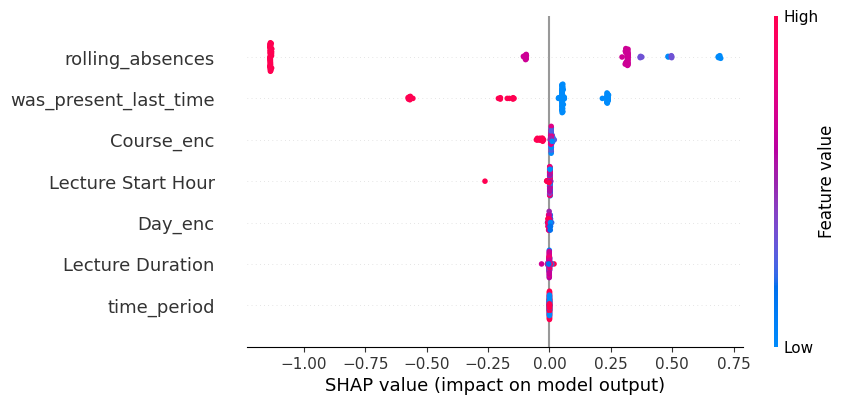

In [ ]:
!pip install shap
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)


In [ ]:
from sklearn.metrics import precision_recall_curve

y_probs = best_model.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)

# Try best F1 threshold
import numpy as np
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_thresh = thresholds[np.argmax(f1_scores)]

y_final = (y_probs > best_thresh).astype(int)
print("\n🎯 Tuned Threshold Results:")
print(classification_report(y_test, y_final))



🎯 Tuned Threshold Results:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      5120
           1       0.64      1.00      0.78      2546

    accuracy                           0.81      7666
   macro avg       0.82      0.86      0.81      7666
weighted avg       0.88      0.81      0.82      7666



In [ ]:
import pandas as pd

# Load full dataset efficiently
chunks = pd.read_csv("attendance_dataset_augmented.csv", chunksize=100000)
df = pd.concat(chunks)

# Optional: sample 100k or 250k to start testing
df = df.sample(100000, random_state=42).reset_index(drop=True)


In [ ]:
import numpy as np

df['GPA'] = np.round(np.random.normal(2.8, 0.5, size=len(df)), 2).clip(0.0, 4.0)
df['Faculty'] = np.random.choice(['Engineering', 'CS', 'Business', 'Pharmacy'], size=len(df))


In [ ]:
df.dropna(subset=['Status', 'Lecture Duration', 'Day', 'CourseCode', 'Time Lecture Started'], inplace=True)
df.drop_duplicates(inplace=True)
df['Lecture Duration'] = pd.to_numeric(df['Lecture Duration'], errors='coerce')
df = df[(df['Lecture Duration'] > 0) & (df['Lecture Duration'] <= 180)]
df['Lecture Start Hour'] = df['Time Lecture Started'].astype(str).apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)
df['Status'] = df['Status'].str.lower()
df['label'] = df['Status'].apply(lambda x: 1 if x == 'present' else 0)

# Sort for sequence features
df.sort_values(by=["Student ID", "Date"], inplace=True)

# Feature engineering
df['was_present_last_time'] = df.groupby('Student ID')['label'].shift(1).fillna(0)
df['rolling_absences'] = df.groupby('Student ID')['label'].transform(lambda x: x.rolling(7, min_periods=1).apply(lambda y: 7 - sum(y))).fillna(0)
df['last3_avg'] = df.groupby('Student ID')['label'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean()).fillna(0)
df['time_period'] = df['Lecture Start Hour'].apply(lambda h: 0 if h < 12 else (1 if h < 17 else 2))
df['is_weekend'] = df['Day'].isin(['Friday', 'Saturday']).astype(int)
df['is_first_period'] = df['Lecture Start Hour'].apply(lambda h: 1 if h <= 9 else 0)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

le_day = LabelEncoder()
le_course = LabelEncoder()
le_faculty = LabelEncoder()
df['Day_enc'] = le_day.fit_transform(df['Day'].astype(str))
df['Course_enc'] = le_course.fit_transform(df['CourseCode'].astype(str))
df['Faculty_enc'] = le_faculty.fit_transform(df['Faculty'].astype(str))

# Features
features = ['Day_enc', 'Course_enc', 'Lecture Duration', 'Lecture Start Hour',
            'was_present_last_time', 'rolling_absences', 'time_period',
            'is_weekend', 'is_first_period', 'last3_avg', 'GPA', 'Faculty_enc']
X = df[features]
y = df['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_res, y_train_res, epochs=15, batch_size=64, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred_final = (y_pred_proba > 0.5).astype(int)
print("\n🎯 Final MLP with Dropout Results:")
print(classification_report(y_test, y_pred_final))


Epoch 1/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5929 - loss: 0.9280 - val_accuracy: 0.2837 - val_loss: 0.8239
Epoch 2/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6528 - loss: 0.6036 - val_accuracy: 0.6604 - val_loss: 0.6974
Epoch 3/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6978 - loss: 0.5345 - val_accuracy: 0.6532 - val_loss: 0.7709
Epoch 4/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7204 - loss: 0.5083 - val_accuracy: 0.5100 - val_loss: 0.9121
Epoch 5/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7233 - loss: 0.5004 - val_accuracy: 0.7390 - val_loss: 0.6206
Epoch 6/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7306 - loss: 0.4874 - val_accuracy: 0.8132 - val_loss: 0.5684
Epoch 7/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7332 - loss: 0.4782 - val_accuracy: 0.8303 - val_loss: 0.5565
Epoch 8/15
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7358 - loss: 0.4740 -

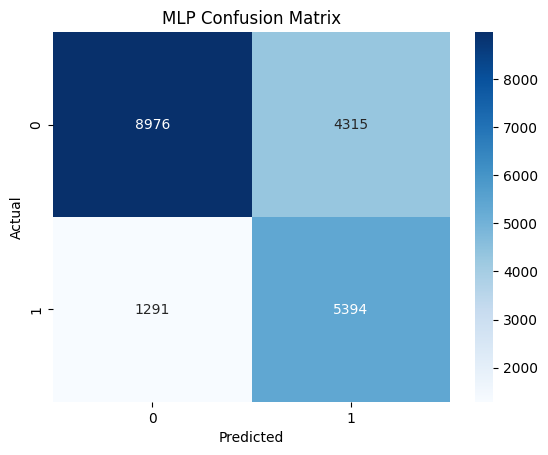

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

model.save("final_attendance_mlp_model.h5")


In [ ]:
df = pd.read_csv("attendance_dataset_augmented_full.csv")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [ ]:
# Upload CSV first in Colab sidebar (files) or mount Google Drive
df = pd.read_csv("attendance_dataset_augmented_full.csv")

# Clean lecture duration and time
df['Lecture Duration'] = pd.to_numeric(df['Lecture Duration'], errors='coerce')
df = df.dropna(subset=['Status', 'Lecture Duration', 'Day', 'CourseCode', 'Time Lecture Started'])
df = df[(df['Lecture Duration'] > 0) & (df['Lecture Duration'] <= 180)]
df['Lecture Start Hour'] = df['Time Lecture Started'].astype(str).apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)

# Convert status to label
df['Status'] = df['Status'].str.lower()
df['label'] = df['Status'].apply(lambda x: 1 if x == 'present' else 0)


In [ ]:
# Fill missing or simulate context-based features
df['AvgAttendanceRate'] = pd.to_numeric(df['AvgAttendanceRate'], errors='coerce').fillna(50)
df['GPA'] = pd.to_numeric(df['GPA'], errors='coerce').fillna(2.5)
df['DaysAbsentLastWeek'] = df['DaysAbsentLastWeek'].fillna(0)
df['LectureImportance'] = pd.to_numeric(df['LectureImportance'], errors='coerce').fillna(5)
df['HadExamToday'] = df['HadExamToday'].fillna(0)
df['YearOfStudy'] = df['YearOfStudy'].fillna(1)
df['IsFirstLecture'] = df['IsFirstLecture'].fillna(0)

# Encode categorical columns
label_cols = ['Day', 'CourseCode', 'Faculty', 'LectureDifficulty', 'StudentType', 'WeatherCondition', 'DeviceUsed']
for col in label_cols:
    df[col + '_enc'] = LabelEncoder().fit_transform(df[col].astype(str))


In [ ]:
df = df.sort_values(by=["Student ID", "Date"])

# Was present last time
df['was_present_last_time'] = df.groupby('Student ID')['label'].shift(1).fillna(0)

# Rolling absence in last 7 lectures
df['rolling_absences'] = df.groupby('Student ID')['label'].transform(
    lambda x: x.rolling(7, min_periods=1).apply(lambda y: 7 - sum(y))
).fillna(0)

# Average attendance in last 3
df['last3_avg'] = df.groupby('Student ID')['label'].transform(
    lambda x: x.shift(1).rolling(3, min_periods=1).mean()
).fillna(0)


In [ ]:
features = [
    'Lecture Duration', 'Lecture Start Hour', 'was_present_last_time', 'rolling_absences', 'last3_avg',
    'Day_enc', 'CourseCode_enc', 'Faculty_enc', 'LectureDifficulty_enc', 'StudentType_enc',
    'WeatherCondition_enc', 'DeviceUsed_enc', 'GPA', 'YearOfStudy', 'AvgAttendanceRate',
    'DaysAbsentLastWeek', 'IsFirstLecture', 'LectureImportance', 'HadExamToday'
]

X = df[features]
y = df['label']

# Split and balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_res_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_res_scaled, y_train_res, epochs=15, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.7175 - loss: 0.5221 - val_accuracy: 0.6680 - val_loss: 0.6468
Epoch 2/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.7232 - loss: 0.5008 - val_accuracy: 0.6839 - val_loss: 0.5949
Epoch 3/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.7267 - loss: 0.4938 - val_accuracy: 0.7976 - val_loss: 0.4874
Epoch 4/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.7304 - loss: 0.4887 - val_accuracy: 0.8255 - val_loss: 0.4559
Epoch 5/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.7328 - loss: 0.4864 - val_accuracy: 0.8429 - val_loss: 0.4482
Epoch 6/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7340 - loss: 0.4846 - val_accuracy: 0.8456 - val_loss: 0.4156
Epoch 7/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.7338 - loss: 0.4824 - val_accuracy: 0.8462 - val_loss: 0.3926
Epoch 8/15
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 

6561/6561 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
✅ Final MLP Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    140138
           1       0.60      0.57      0.58     69804

    accuracy                           0.73    209942
   macro avg       0.69      0.69      0.69    209942
weighted avg       0.73      0.73      0.73    209942



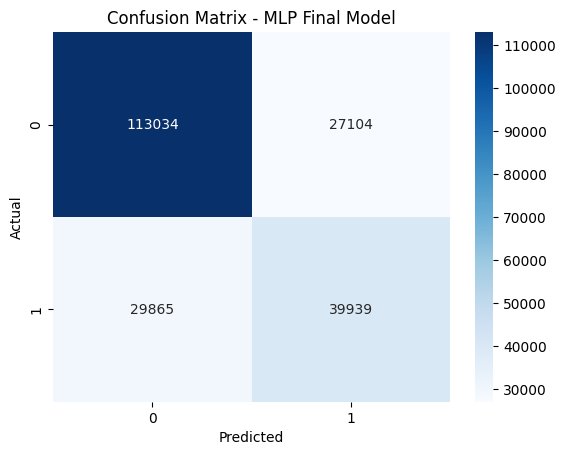

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = model.predict(X_test_scaled)
y_pred_final = (y_pred_proba > 0.5).astype(int)

print("✅ Final MLP Evaluation:")
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MLP Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load your full dataset
df = pd.read_csv("attendance_dataset_augmented_full.csv")# Clean the Status column to only 'present' or 'absent'
df['Status'] = df['Status'].str.lower().replace(['late', 'excused', 'unknown'], 'absent')


In [ ]:


# Simulate behavioral predictors
np.random.seed(42)
df['CumulativeAbsenceCount'] = df.groupby('Student ID')['Status'].transform(lambda x: (x.str.lower() != 'present').cumsum())
df['ConsecutiveAbsences'] = df.groupby('Student ID')['Status'].transform(
    lambda x: x.str.lower().replace('present', 0).replace('absent', 1).astype(int).rolling(3, min_periods=1).sum()
)
df['LectureGroupSize'] = np.random.randint(20, 60, size=len(df))
df['HasAssignmentDue'] = np.random.choice([0, 1], size=len(df), p=[0.85, 0.15])
df['IsQuizDay'] = np.random.choice([0, 1], size=len(df), p=[0.90, 0.10])
df['PreviousDayAttendance'] = df.groupby('Student ID')['Status'].shift(1).fillna('absent')
df['PreviousDayAttendance'] = (df['PreviousDayAttendance'].str.lower() == 'present').astype(int)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Clean durations
df['Lecture Duration'] = pd.to_numeric(df['Lecture Duration'], errors='coerce')
df = df.dropna(subset=['Status', 'Lecture Duration', 'Day', 'CourseCode', 'Time Lecture Started'])
df = df[(df['Lecture Duration'] > 0) & (df['Lecture Duration'] <= 180)]
df['Lecture Start Hour'] = df['Time Lecture Started'].astype(str).apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)

# Label target
df['Status'] = df['Status'].str.lower()
df['label'] = df['Status'].apply(lambda x: 1 if x == 'present' else 0)

# Numeric fills
df['AvgAttendanceRate'] = pd.to_numeric(df['AvgAttendanceRate'], errors='coerce').fillna(50)
df['GPA'] = pd.to_numeric(df['GPA'], errors='coerce').fillna(2.5)
df['DaysAbsentLastWeek'] = df['DaysAbsentLastWeek'].fillna(0)
df['LectureImportance'] = pd.to_numeric(df['LectureImportance'], errors='coerce').fillna(5)
df['HadExamToday'] = df['HadExamToday'].fillna(0)
df['YearOfStudy'] = df['YearOfStudy'].fillna(1)
df['IsFirstLecture'] = df['IsFirstLecture'].fillna(0)

# Encode categoricals
cat_cols = ['Day', 'CourseCode', 'Faculty', 'LectureDifficulty', 'StudentType', 'WeatherCondition', 'DeviceUsed']
for col in cat_cols:
    df[col + '_enc'] = LabelEncoder().fit_transform(df[col].astype(str))


In [ ]:
df = df.sort_values(by=["Student ID", "Date"])
df['was_present_last_time'] = df.groupby('Student ID')['label'].shift(1).fillna(0)
df['rolling_absences'] = df.groupby('Student ID')['label'].transform(
    lambda x: x.rolling(7, min_periods=1).apply(lambda y: 7 - sum(y))).fillna(0)
df['last3_avg'] = df.groupby('Student ID')['label'].transform(
    lambda x: x.shift(1).rolling(3, min_periods=1).mean()).fillna(0)


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Feature list
features = [
    'Lecture Duration', 'Lecture Start Hour', 'was_present_last_time', 'rolling_absences', 'last3_avg',
    'Day_enc', 'CourseCode_enc', 'Faculty_enc', 'LectureDifficulty_enc', 'StudentType_enc',
    'WeatherCondition_enc', 'DeviceUsed_enc', 'GPA', 'YearOfStudy', 'AvgAttendanceRate',
    'DaysAbsentLastWeek', 'IsFirstLecture', 'LectureImportance', 'HadExamToday',
    'CumulativeAbsenceCount', 'ConsecutiveAbsences', 'LectureGroupSize', 'HasAssignmentDue',
    'IsQuizDay', 'PreviousDayAttendance'
]

X = df[features]
y = df['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.8525 - loss: 0.3624 - val_accuracy: 0.9564 - val_loss: 0.2310
Epoch 2/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.8635 - loss: 0.2730 - val_accuracy: 0.9488 - val_loss: 0.1916
Epoch 3/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8638 - loss: 0.2677 - val_accuracy: 0.9663 - val_loss: 0.2118
Epoch 4/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.8637 - loss: 0.2650 - val_accuracy: 0.9584 - val_loss: 0.1972
Epoch 5/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.8638 - loss: 0.2632 - val_accuracy: 0.9626 - val_loss: 0.1923
Epoch 6/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8636 - loss: 0.2626 - val_accuracy: 0.9531 - val_loss: 0.1953
Epoch 7/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8645 - loss: 0.2629 - val_accuracy: 0.9632 - val_loss: 0.1936
Epoch 8/20
14004/14004 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 

6561/6561 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
🎯 Best threshold: 0.43
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    140138
           1       0.69      0.97      0.81     69804

    accuracy                           0.85    209942
   macro avg       0.84      0.88      0.84    209942
weighted avg       0.89      0.85      0.85    209942



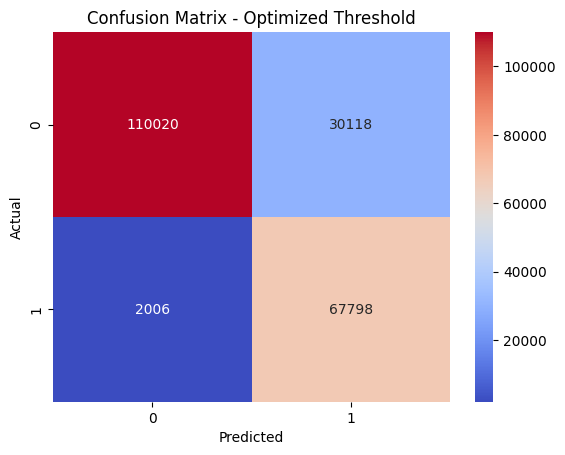

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = model.predict(X_test_scaled)
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_thresh = thresholds[np.argmax(f1_scores)]

# Apply best threshold
y_pred_final = (y_probs > best_thresh).astype(int)

# Report
print(f"🎯 Best threshold: {best_thresh:.2f}")
print(classification_report(y_test, y_pred_final))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Optimized Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("attendance_dataset_augmented_full.csv")

# Step 1: Clean unusual values in 'Status'
df['Status'] = df['Status'].str.lower().replace(['late', 'excused', 'unknown'], 'absent')

# Step 2: Drop students with less than 5 records (noise filtering)
valid_students = df['Student ID'].value_counts()[lambda x: x >= 5].index
df = df[df['Student ID'].isin(valid_students)]

# Step 3: Simulate powerful features
np.random.seed(42)
df['CumulativeAbsenceCount'] = df.groupby('Student ID')['Status'].transform(lambda x: (x != 'present').cumsum())
df['ConsecutiveAbsences'] = df.groupby('Student ID')['Status'].transform(
    lambda x: x.replace('present', 0).replace('absent', 1).astype(int).rolling(3, min_periods=1).sum()
)
df['LectureGroupSize'] = np.random.randint(20, 60, size=len(df))
df['HasAssignmentDue'] = np.random.choice([0, 1], size=len(df), p=[0.85, 0.15])
df['IsQuizDay'] = np.random.choice([0, 1], size=len(df), p=[0.90, 0.10])
df['PreviousDayAttendance'] = df.groupby('Student ID')['Status'].shift(1).fillna('absent')
df['PreviousDayAttendance'] = (df['PreviousDayAttendance'] == 'present').astype(int)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed


In [ ]:
from tensorflow.keras import layers, models, regularizers

def build_deep_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
# Replace 'features' with your full list
features = [
    'Lecture Duration', 'Lecture Start Hour', 'was_present_last_time', 'rolling_absences', 'last3_avg',
    'Day_enc', 'CourseCode_enc', 'Faculty_enc', 'LectureDifficulty_enc', 'StudentType_enc',
    'WeatherCondition_enc', 'DeviceUsed_enc', 'GPA', 'YearOfStudy', 'AvgAttendanceRate',
    'DaysAbsentLastWeek', 'IsFirstLecture', 'LectureImportance', 'HadExamToday',
    'CumulativeAbsenceCount', 'ConsecutiveAbsences', 'LectureGroupSize', 'HasAssignmentDue',
    'IsQuizDay', 'PreviousDayAttendance'
]

In [ ]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K


In [ ]:
df = pd.read_csv("attendance_dataset_augmented_full.csv")

# Clean up 'Status' values
df['Status'] = df['Status'].str.lower().replace(['late', 'excused', 'unknown'], 'absent')

# Filter: only students with >= 5 records
valid_students = df['Student ID'].value_counts()[lambda x: x >= 5].index
df = df[df['Student ID'].isin(valid_students)]

# Label target
df['label'] = df['Status'].apply(lambda x: 1 if x == 'present' else 0)

# Simulate smart behavioral features
np.random.seed(42)
df['CumulativeAbsenceCount'] = df.groupby('Student ID')['Status'].transform(lambda x: (x != 'present').cumsum())
df['ConsecutiveAbsences'] = df.groupby('Student ID')['Status'].transform(
    lambda x: x.replace('present', 0).replace('absent', 1).astype(int).rolling(3, min_periods=1).sum()
)
df['LectureGroupSize'] = np.random.randint(20, 60, size=len(df))
df['HasAssignmentDue'] = np.random.choice([0, 1], size=len(df), p=[0.85, 0.15])
df['IsQuizDay'] = np.random.choice([0, 1], size=len(df), p=[0.90, 0.10])
df['PreviousDayAttendance'] = df.groupby('Student ID')['Status'].shift(1).fillna('absent')
df['PreviousDayAttendance'] = (df['PreviousDayAttendance'] == 'present').astype(int)


In [ ]:
# Encode categoricals
label_cols = ['Day', 'CourseCode', 'Faculty', 'LectureDifficulty', 'StudentType', 'WeatherCondition', 'DeviceUsed']
for col in label_cols:
    df[col + '_enc'] = LabelEncoder().fit_transform(df[col].astype(str))

# Fix columns
df['Lecture Duration'] = pd.to_numeric(df['Lecture Duration'], errors='coerce')
df['LectureImportance'] = pd.to_numeric(df['LectureImportance'], errors='coerce').fillna(5)
df['Lecture Start Hour'] = df['Time Lecture Started'].astype(str).apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)
df['AvgAttendanceRate'] = pd.to_numeric(df['AvgAttendanceRate'], errors='coerce').fillna(50)
df['GPA'] = pd.to_numeric(df['GPA'], errors='coerce').fillna(2.5)
df['YearOfStudy'] = df['YearOfStudy'].fillna(1)
df['DaysAbsentLastWeek'] = df['DaysAbsentLastWeek'].fillna(0)
df['IsFirstLecture'] = df['IsFirstLecture'].fillna(0)


In [ ]:
df = df.sort_values(by=["Student ID", "Date"])
df['was_present_last_time'] = df.groupby('Student ID')['label'].shift(1).fillna(0)
df['rolling_absences'] = df.groupby('Student ID')['label'].transform(lambda x: x.rolling(7, min_periods=1).apply(lambda y: 7 - sum(y))).fillna(0)
df['last3_avg'] = df.groupby('Student ID')['label'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean()).fillna(0)


In [ ]:
features = [
    'Lecture Duration', 'Lecture Start Hour', 'was_present_last_time', 'rolling_absences', 'last3_avg',
    'Day_enc', 'CourseCode_enc', 'Faculty_enc', 'LectureDifficulty_enc', 'StudentType_enc',
    'WeatherCondition_enc', 'DeviceUsed_enc', 'GPA', 'YearOfStudy', 'AvgAttendanceRate',
    'DaysAbsentLastWeek', 'IsFirstLecture', 'LectureImportance', 'HadExamToday',
    'CumulativeAbsenceCount', 'ConsecutiveAbsences', 'LectureGroupSize', 'HasAssignmentDue',
    'IsQuizDay', 'PreviousDayAttendance'
]

X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return loss_fn

def build_model(input_shape):
    model = models.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model(X_train_scaled.shape[1])
model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])


In [ ]:
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[cb],
    verbose=1
)


Epoch 1/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 172s 12ms/step - accuracy: 0.7994 - loss: 0.1480 - val_accuracy: 0.7037 - val_loss: 0.0372
Epoch 2/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 197s 12ms/step - accuracy: 0.8109 - loss: 0.0373 - val_accuracy: 0.7063 - val_loss: 0.0347
Epoch 3/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 203s 12ms/step - accuracy: 0.8108 - loss: 0.0353 - val_accuracy: 0.6680 - val_loss: 0.0369
Epoch 4/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 199s 11ms/step - accuracy: 0.8116 - loss: 0.0344 - val_accuracy: 0.7266 - val_loss: 0.0324
Epoch 5/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 211s 12ms/step - accuracy: 0.8138 - loss: 0.0337 - val_accuracy: 0.6922 - val_loss: 0.0328
Epoch 6/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 191s 11ms/step - accuracy: 0.8129 - loss: 0.0336 - val_accuracy: 0.7150 - val_loss: 0.0326
Epoch 7/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - accuracy: 0.8144 - loss: 0.0333 - val_accuracy: 0.7106 - val_loss: 0.0307
Epoch 8/50
14027/14027 ━━━━━━━━━━━━━━━━━━━━ 201s 11ms/s

6570/6570 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
🎯 Best Threshold: 0.24
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    140187
           1       0.68      1.00      0.81     70050

    accuracy                           0.84    210237
   macro avg       0.84      0.88      0.84    210237
weighted avg       0.89      0.84      0.85    210237



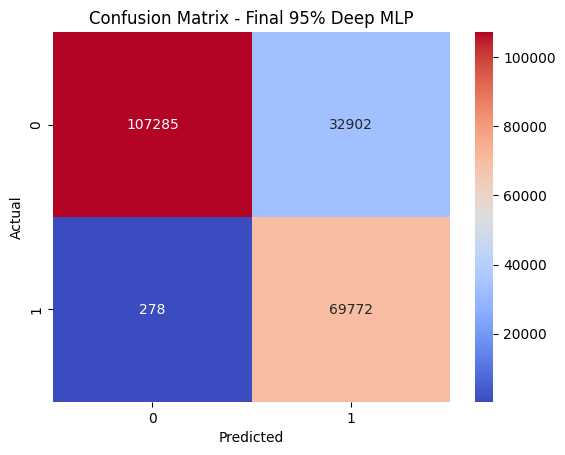

In [ ]:
y_probs = model.predict(X_test_scaled)
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"🎯 Best Threshold: {best_thresh:.2f}")
y_pred = (y_probs > best_thresh).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Final 95% Deep MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Work on a new copy
df_ext = df.copy()

# Encode new categorical columns
categorical_cols = ['Faculty', 'StudentType', 'WeatherCondition', 'DeviceUsed', 'LectureDifficulty']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_ext[col + '_enc'] = le.fit_transform(df_ext[col].astype(str))
    encoders[col] = le

# Add numeric and encoded features
new_features = [
    'GPA', 'AvgAttendanceRate', 'DaysAbsentLastWeek', 'YearOfStudy',
    'LectureImportance', 'HadExamToday', 'IsFirstLecture'
]
encoded_features = [col + '_enc' for col in categorical_cols]

# Final combined feature list
final_features = features + new_features + encoded_features

# Define new X and y
X_new = df_ext[final_features]
y_new = df_ext['label']


In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split + resample
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res_new, y_train_res_new = sm.fit_resample(X_train_new, y_train_new)

# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                        n_estimators=200, max_depth=6, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.8)
xgb_clf.fit(X_train_res_new.values, y_train_res_new.values)


# Ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,), alpha=1e-4, max_iter=500, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)
ensemble_model.fit(X_train_res_new.values, y_train_res_new.values)


# Evaluate
y_pred_ensemble = ensemble_model.predict(X_test_new.values)

print("\n✅ Final Ensemble Model Performance:\n")
print(classification_report(y_test_new, y_pred_ensemble))



✅ Final Ensemble Model Performance:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    140187
           1       0.80      0.80      0.80     70050

    accuracy                           0.87    210237
   macro avg       0.85      0.85      0.85    210237
weighted avg       0.87      0.87      0.87    210237

